In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def lift(x, i, offset, vals):
    v = x[i + offset] * vals[0]
    if len(vals) > 1:
        return v + lift(x, i, offset + 1, vals[1:])
    else:
        return v

def lift_zero(x, i, n, offset, vals):
    io = i + offset
    if io >= n:
        return x.dtype.type(0.0)
    elif io < 0:
        if len(vals) > 1:
            return lift_zero(x, i, n, offset + 1, vals[1:])
        else:
            return x.dtype.type(0.0)

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + lift_zero(x, i, n, offset + 1, vals[1:])
    else:
        return v

def lift_wrap(x, i, n, offset, vals):
    io = (i + offset) % n

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + lift_wrap(x, i, n, offset + 1, vals[1:])
    else:
        return v

def lift_const(x, i, n, offset, vals):
    io = i + offset
    if io > n - 1:
        io = n - 1
    elif io < 0:
        io = 0
    
    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + lift_const(x, i, n, offset + 1, vals[1:])
    else:
        return v

def lift_symm(x, i, n, offset, vals):
    io = i + offset
    if io >= n:
        io = n - 1 - (io - n)
    elif io < 0:
        io = -(io + 1)

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + lift_symm(x, i, n, offset + 1, vals[1:])
    else:
        return v


def lift_refl(x, i, n, offset, vals):
    io = i + offset
    if io >= n:
        io = n - 2 - (io - n)
    elif io < 0:
        io = -io

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + lift_refl(x, i, n, offset + 1, vals[1:])
    else:
        return v

In [ ]:
def lift_adj(x, i, offset, vals):
    v = x[i + offset] * vals[0]
    if len(vals) > 1:
        return v + lift(x, i, offset + 1, vals[1:])
    else:
        return v

In [106]:
class update_d:
    
    def __init__(self, offset, vals):
        self.vals = np.asarray(vals, dtype=np.float64).copy()
        self.offset = offset
        self.n_front = 0 if offset > 0 else -offset

        n_vals = len(vals)
        max_off = n_vals - 1 + offset
        self.n_back = 0 if max_off < 0 else max_off

        self.vals_r = np.asarray(vals[::-1], dtype=np.float64).copy()
        self.offset_r = -max_off
        self.n_front_r = 0 if self.offset_r > 0 else -self.offset_r
        
        max_off_r = n_vals - 1 + self.offset_r
        self.n_back_r = 0 if max_off_r < 0 else max_off_r

    def inverse(self, s, d, bc_wrap) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals.astype(s.dtype)

        # s [j] would go from self.offset to nd + self.offset + n_vals


        # touches j indices from offset to min(n_front, nd) + offset + n_vals
        #for i in range(min(self.n_front, nd)):
        #    d[i] -= bc_wrap(s, i, ns, self.offset, self.vals)

        # touches j indices from n_front + offset to nd - n_back + offset + n_vals 
        for i in range(self.n_front, nd - self.n_back):
            d[i] -= lift(s, i, self.offset, self.vals)

        # touches j indices from max(nd - n_back, 0) + offset to nd + offset + n_vals
        #for i in range(max(nd - self.n_back, 0), nd):
        #    d[i] -= bc_wrap(s, i, ns, self.offset, self.vals)

    def inverse_adj(self, s, d, bc_wrap, do_zero, verbose=False) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals.astype(s.dtype)


        # touches j indices from offset to min(n_front, nd) + offset + n_vals
        for i in range(min(self.n_front, nd)):
            s[i] -= bc_wrap(d, i, ns, self.offset, self.vals)

        # touches j indices from n_front + offset to nd - n_back + offset + n_vals 
        for i in range(self.n_front, nd - self.n_back):
            s[i] -= lift(d, i, self.offset, self.vals)

        # touches j indices from max(nd - n_back, 0) + offset to nd + offset + n_vals
        for i in range(max(nd - self.n_back, 0), nd):
            s[i] -= bc_wrap(d, i, ns, self.offset, self.vals)

        # if verbose:
        #     print(n_vals, self.offset, self.offset_r)
        # for i in range(0, ns - n_vals):
        #     s[i] -= lift_adj(d, i, self.offset, vals)


In [107]:
def inverse_transform(wvlt, s, d, mode="periodic"):
    if mode == 'periodic':
        bc_wrap = lift_wrap
    elif mode == 'zero':
        bc_wrap = lift_zero
    elif mode == 'constant':
        bc_wrap = lift_const
    elif mode == 'symmetric':
        bc_wrap = lift_symm
    elif mode == 'reflect':
        bc_wrap = lift_refl
    
    s = s.copy()
    d = d.copy()

    for step in wvlt.steps[::-1]:
        step.inverse(s, d, bc_wrap)

    x = np.empty(len(s) + len(d), dtype=s.dtype)
    x[::2] = s
    x[1::2] = d
    return x

In [108]:
def lift_zero_adj(x, i, nx, ny, offset, vals, verbose=0):
    if i < 0:
        return 0, x.dtype.type(0)
    if i >= ny:
        return 0, x.dtype.type(0)
    else:
        return i, lift_zero(x, i, nx, offset, vals)
    if i <= ny:
        return i, 
    return 0, x.dtype.type(0)


def lift_refl_adj(x, i, nx, ny, offset, vals):
    return 0, x.dtype.type(0)

In [109]:
def inverse_adjoint(wvlt, x, mode="periodic", verbose=0):
    do_zero = False
    if mode == 'periodic':
        bc_wrap = lift_wrap_adj
        do_zero = False
    elif mode == 'zero':
        bc_wrap = lift_zero_adj
        do_zero = False
    elif mode == 'constant':
        bc_wrap = lift_const_adj
    elif mode == 'symmetric':
        bc_wrap = lift_symm_adj
    elif mode == 'reflect':
        bc_wrap = lift_refl
    s = x[::2].copy()
    d = x[1::2].copy()

    for step in wvlt.steps:
        step.inverse_adj(s, d, bc_wrap, do_zero=do_zero, verbose=verbose)

    return s, d

In [189]:
def get_mats(wvlt, mode, n):
    inv_mats = []
    inv_mats_zero = []
    inv_adj_mats = []

    verbose = 1
    for i in range(n):
        e = np.zeros(n)
        e[i] = 1
        nd = len(e)//2
        ns = len(e) - nd
        es = e[:ns]
        ed = e[ns:]
        
        # s, d = forward_transform(TestDWavelet, e, mode=mode)
        # for_mats.append(np.r_[s, d])
        inv_mats.append(inverse_transform(wvlt, es, ed, mode=mode))
        inv_mats_zero.append(inverse_transform(wvlt, es, ed, mode="zero"))

        # es = e[::2]
        # ed = e[1::2]
        # inv_mats.append(inverse_transform(wvlt, es, ed, mode=mode))
    
        #for_adj_mats.append(forward_adjoint(TestDWavelet, es, ed, mode=mode))
        s, d = inverse_adjoint(wvlt, e, mode=mode, verbose=verbose)
        inv_adj_mats.append(np.r_[s, d])
        
        verbose = 0

    inv_mats = np.stack(inv_mats, axis=1)
    inv_mats_zero = np.stack(inv_mats_zero, axis=1)
    inv_adj_mats = np.stack(inv_adj_mats, axis=1)
    return inv_mats, inv_mats_zero, inv_adj_mats

In [190]:
def lift_zero_adj(x, i, nx, ny, offset, vals, verbose=False):
    if i < 0:
        return 0, x.dtype.type(0)
    if i >= ny:
        return 0, x.dtype.type(0)
    else:
        return i, lift_zero(x, i, nx, offset, vals)
    if i <= ny:
        return i, 
    return 0, x.dtype.type(0)

In [191]:
def lift_const_adj(x, i, nx, ny, offset, vals, verbose=False):
    n_vals = len(vals)
    if i < 0:
        i_start = 0
        i_end = min(i + offset + n_vals, nx)
        vj = -(i + offset) % n_vals
        i = 0
    elif i >= nx:
        i_start = max(i + offset, 0) 
        i_end = nx
        vj = max(-(i + offset), 0) % n_vals
        i = ny - 1
    else:
        return i, lift_zero(x, i, nx, offset, vals)

    v = x.dtype.type(0)
    for ii in range(i_start, i_end):
        v += vals[vj] * x[ii]
        vj = (vj + 1) % n_vals

    return i, v

In [192]:
def lift_wrap_adj(x, i, nx, ny, offset, vals, verbose=False):
    n_vals = len(vals)
    v = x.dtype.type(0)
    i_start = i + offset
    i_end = i_start + n_vals

    if i_start < 0:
        i_start = i_start % ny
        i_end = min(i_start + n_vals, nx)
        if i_start + n_vals == nx:
            return 0, 0
        j = 0
        for io in range(i_start, i_end):
            v += vals[j] * x[io]
            j += 1
        
        return i % ny, v
    elif i_start >= 0:
        j = -(i_start % ny - ny)
        i_end = (n_vals - j)
        i_start = 0

        for io in range(i_start, i_end):
            v += vals[j] * x[io]
            j += 1
        
        return i % ny, v
    
    return 0, v

In [193]:
def lift_adj(x, i, offset_r, offset, vals):
    v = 0
    if len(vals) == 0:
        return v
    io = i + offset
    if io < len(x):
        v = 0
    else:
        v = vals[0] * x[io]
    return v + lift_adj(x, i, offset + 1, vals[1:])

In [194]:
class TestDWavelet:
    steps = (
        update_d(-4, [-2, -4, -6, -8, -10, -12, -14]),
    )

In [195]:
inv_mats, inv_mats_zero, inv_adj_mats = get_mats(TestDWavelet, 'zero', n = 32)

7 -4 -2


TypeError: lift_adj() missing 1 required positional argument: 'vals'

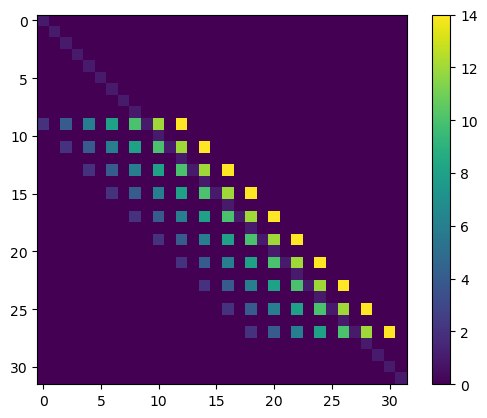

In [196]:
plt.imshow(inv_mats)
plt.colorbar()

TypeError: Invalid shape () for image data

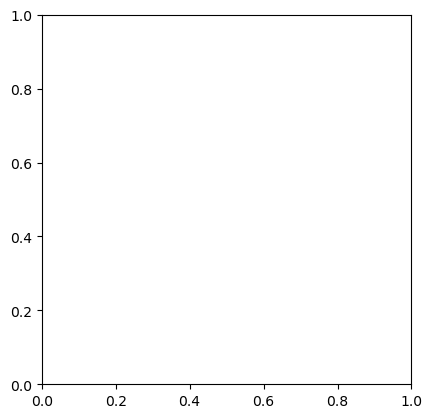

In [172]:
plt.imshow(inv_adj_mats)
plt.colorbar()

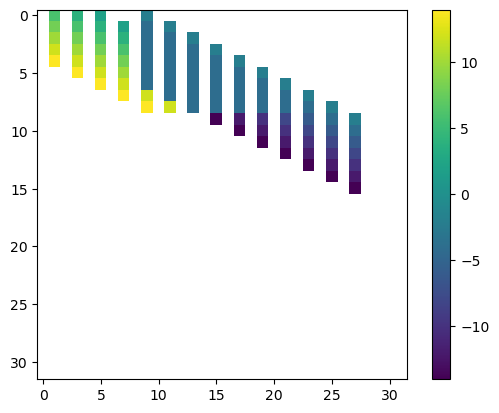

In [145]:
im = inv_adj_mats - inv_mats_zero.T
im[im == 0] = np.nan
plt.imshow(im)
plt.colorbar()

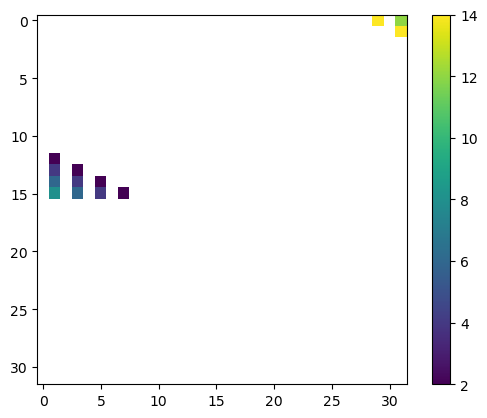

In [3364]:
im = (inv_mats - inv_mats_zero).T
im[im == 0] = np.nan
plt.imshow(im)
plt.colorbar()

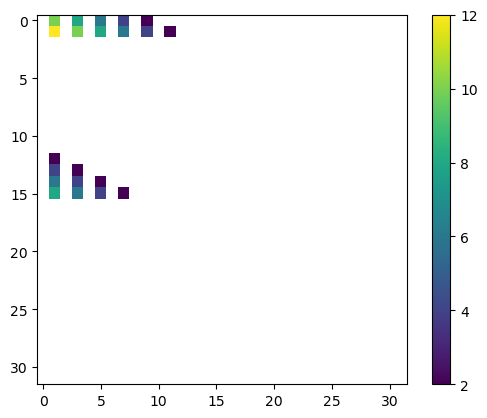

In [3365]:
im = inv_mats.T - inv_adj_mats
im[im == 0] = np.nan
plt.imshow(im)
plt.colorbar()

In [2867]:
#(inv_mats - inv_mats_zero).T[0:7, :12]
(inv_mats - inv_mats_zero).T[[0, 15], 1::2]
#inv_mats.T[9:16, -12:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.]])

In [2848]:
# np.round((inv_adj_mats- inv_mats_zero.T)[0:7, :12])
np.round((inv_adj_mats - inv_mats_zero.T)[[0, 15], 1::2])
# np.round(inv_adj_mats[9:16, -12:])

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56.]])

In [2849]:
np.round((inv_mats.T - inv_adj_mats)[[0, 15], 1::2])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
(inv_mats - inv_mats_zero).T[[0, 15], 1::2]

In [2256]:
(inv_mats - inv_mats_zero).T[9:16, -12:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [1909]:
np.round((inv_adj_mats - inv_mats_zero.T)[9:16, -12:])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])